In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [32]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from local.lib import mlutils
import pickle, bz2
%matplotlib inline

## Observe AlexNet filters for the first two convolutional layers

Pretrained Network: https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/

Paper: [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

Source images: [Large Scale Visual Recognition Challenge 2012](http://www.image-net.org/challenges/LSVRC/2012/) [ImageNet](http://www.image-net.org)

Local file with weights from first two layers only



In [3]:
!ls -lash local/data/alexnet_conv1_conv2.pklz

1,4M -rw-r--r-- 1 rlx rlx 1,4M nov  6 20:18 local/data/alexnet_conv1_conv2.pklz


In [4]:
alex_c12 = pickle.load(bz2.BZ2File("local/data/alexnet_conv1_conv2.pklz", "r"), encoding="bytes")
for k,(w,b) in alex_c12.items():
    print(k, b.shape, w.shape)

b'conv2' (256,) (5, 5, 48, 256)
b'conv1' (96,) (11, 11, 3, 96)


we use for the moment only the first layer

(11, 11, 3, 96)


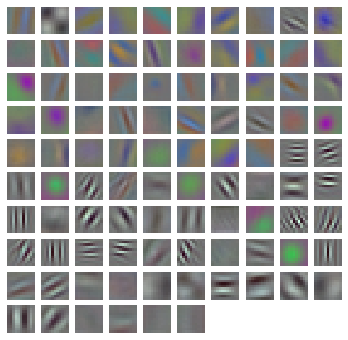

In [5]:
alex_w1 = alex_c12[b"conv1"][0]
print(alex_w1.shape)
mlutils.display_imgs(alex_w1)

### We will use them as starting point for training our network

In [10]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5

File ‘mini_cifar.h5’ already there; not retrieving.



In [11]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

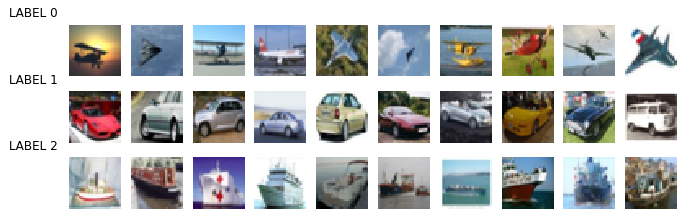

In [12]:
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("\ndistribution of train classes")
print(pd.Series(y_train).value_counts())
print("\ndistribution of test classes")
print(pd.Series(y_test).value_counts())

(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
0    755
2    754
1    744
dtype: int64

distribution of test classes
2    271
0    250
1    230
dtype: int64


In [26]:
def get_model(num_classes, img_size=32, compile=True):
    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [28]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [31]:
num_classes = len(np.unique(y_cifar))
model = get_model(num_classes)
model.summary()

using 3 classes
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten_3 (Flatten)          (None, 60)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)    

## Train from scratch

in some runs might take a while to start reducing loss

In [32]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned")

Train on 2253 samples, validate on 751 samples
Epoch 1/15
2253/2253 [==============================] - 3s 1ms/sample - loss: 1.0993 - accuracy: 0.3853 - val_loss: 1.0354 - val_accuracy: 0.5126
Epoch 2/15
2253/2253 [==============================] - 3s 1ms/sample - loss: 1.0427 - accuracy: 0.4749 - val_loss: 0.9582 - val_accuracy: 0.5273
Epoch 3/15
2253/2253 [==============================] - 3s 1ms/sample - loss: 1.0252 - accuracy: 0.4780 - val_loss: 0.9387 - val_accuracy: 0.5672
Epoch 4/15
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.9817 - accuracy: 0.5126 - val_loss: 0.8964 - val_accuracy: 0.5726
Epoch 5/15
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.9556 - accuracy: 0.5255 - val_loss: 0.8881 - val_accuracy: 0.5872
Epoch 6/15
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.9316 - accuracy: 0.5220 - val_loss: 0.8841 - val_accuracy: 0.5965
Epoch 7/15
2253/2253 [==============================] - 3s 1ms/sample - loss:

{'loss': 0.8053357077343327, 'accuracy': 0.6111851}

Normalized confusion matrix
[[0.512      0.096      0.392     ]
 [0.12173913 0.71304348 0.16521739]
 [0.24723247 0.13653137 0.61623616]]


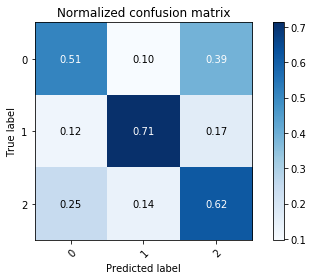

In [33]:
test_preds = model.predict(x_test).argmax(axis=1)
mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

## Transfer learning!!!

- Keep first level filters to compare later


In [42]:
model = get_model(num_classes)
w = model.get_weights()
for i in w:
    print(i.shape)

using 3 classes
(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 16)
(16,)
(16, 3)
(3,)


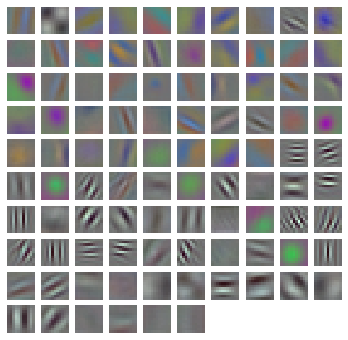

In [43]:
w[0] = alex_w1
model.set_weights(w)
mlutils.display_imgs(model.get_weights()[0])

In [44]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned")

Train on 2253 samples, validate on 751 samples
Epoch 1/15
2253/2253 [==============================] - 3s 1ms/sample - loss: 1.0591 - accuracy: 0.4581 - val_loss: 0.9006 - val_accuracy: 0.5340
Epoch 2/15
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.9411 - accuracy: 0.5704 - val_loss: 0.8001 - val_accuracy: 0.6897
Epoch 3/15
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.8451 - accuracy: 0.6352 - val_loss: 0.7111 - val_accuracy: 0.7097
Epoch 4/15
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.7718 - accuracy: 0.6733 - val_loss: 0.7252 - val_accuracy: 0.7177
Epoch 5/15
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.6904 - accuracy: 0.7071 - val_loss: 0.6963 - val_accuracy: 0.7324
Epoch 6/15
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.6715 - accuracy: 0.7195 - val_loss: 0.7216 - val_accuracy: 0.7150
Epoch 7/15
2253/2253 [==============================] - 3s 1ms/sample - loss:

{'loss': 0.8002101247224922, 'accuracy': 0.74567246}

Normalized confusion matrix
[[0.808      0.108      0.084     ]
 [0.0826087  0.82173913 0.09565217]
 [0.22509225 0.15129151 0.62361624]]


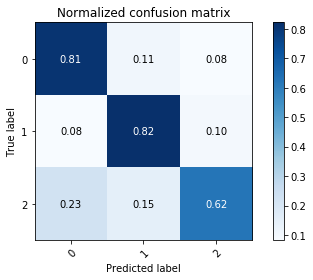

In [45]:
test_preds = model.predict(x_test).argmax(axis=1)
mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

first level filters changed but not much

In [46]:
w0 = model.get_weights()[0]
np.mean(np.abs(w0-alex_w1))

0.021298088

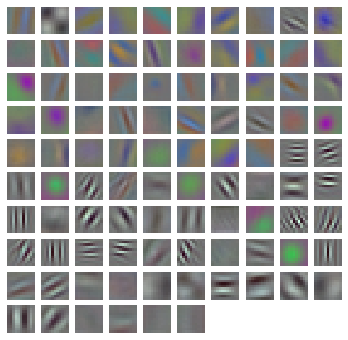

In [47]:
mlutils.display_imgs(w[0])

In [48]:
model.save("alexnet_finetuned_minicifar.model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: alexnet_finetuned_minicifar.model/assets


observe that you can also save separately the architecture

In [49]:
with open('alexnet_finetuned_minicifar.architecture.json', 'w') as f:
    f.write(model.to_json())

In [50]:
!ls -lash alexnet_finetuned_minicifar*

4,0K -rw-r--r-- 1 rlx rlx 3,5K mar 24 18:42 alexnet_finetuned_minicifar.architecture.json

alexnet_finetuned_minicifar.model:
total 172K
4,0K drwxr-xr-x  4 rlx rlx 4,0K mar 24 18:42 .
8,0K drwxrwxr-x 10 rlx rlx 4,0K mar 24 18:42 ..
4,0K drwxr-xr-x  2 rlx rlx 4,0K mar 24 18:42 assets
152K -rw-r--r--  1 rlx rlx 151K mar 24 18:42 saved_model.pb
4,0K drwxr-xr-x  2 rlx rlx 4,0K mar 24 18:42 variables


In [51]:
!head alexnet_finetuned_minicifar.architecture.json

{"class_name": "Model", "config": {"name": "model_5", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 32, 32, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Conv2D", "config": {"name": "conv2d_10", "trainable": true, "dtype": "float32", "filters": 96, "kernel_size": [11, 11], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "name": "conv2d_10", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "MaxPooling2D", "config": {"name": "max_pooling2d_5", "trainable": true, "dtype": "float32", "pool_size": [2, 

## Could also freeze weights to avoid being changed by training

In [74]:
def get_modelT(num_classes, img_size=32, compile=True):
    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu", trainable=False)(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [75]:
model = get_modelT(num_classes)
w = model.get_weights()
w[0] = alex_w1
model.set_weights(w)

using 3 classes


In [78]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned")

Train on 2253 samples, validate on 751 samples
Epoch 1/15
2253/2253 [==============================] - 1s 629us/sample - loss: 0.7692 - accuracy: 0.6067 - val_loss: 0.7014 - val_accuracy: 0.6778
Epoch 2/15
2253/2253 [==============================] - 1s 653us/sample - loss: 0.7722 - accuracy: 0.5872 - val_loss: 0.6172 - val_accuracy: 0.7537
Epoch 3/15
2253/2253 [==============================] - 1s 637us/sample - loss: 0.7305 - accuracy: 0.6081 - val_loss: 0.5964 - val_accuracy: 0.7803
Epoch 4/15
2253/2253 [==============================] - 1s 647us/sample - loss: 0.7131 - accuracy: 0.6156 - val_loss: 0.6610 - val_accuracy: 0.7790
Epoch 5/15
2253/2253 [==============================] - 1s 642us/sample - loss: 0.7252 - accuracy: 0.6161 - val_loss: 0.6024 - val_accuracy: 0.7630
Epoch 6/15
2253/2253 [==============================] - 1s 649us/sample - loss: 0.7256 - accuracy: 0.6028 - val_loss: 0.5994 - val_accuracy: 0.7537
Epoch 7/15
2253/2253 [==============================] - 1s 658us/

{'loss': 0.5750688903341281, 'accuracy': 0.8002663}

Normalized confusion matrix
[[0.836      0.052      0.112     ]
 [0.16086957 0.74782609 0.09130435]
 [0.13284133 0.05535055 0.81180812]]


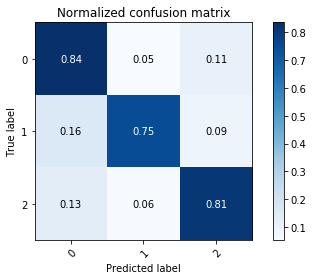

In [79]:
test_preds = model.predict(x_test).argmax(axis=1)
mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

check filters did not change

In [80]:
w0 = model.get_weights()[0]
np.mean(np.abs(w0-alex_w1))

0.0